In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle

from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import RFECV
import warnings
warnings.filterwarnings('ignore')

In [2]:
dataset = pd.read_csv(r'C:/Users/mathe/Desktop/MATHEUS/UFBA/IC/shalegas-rad/dataset_no_blind.csv', index_col=0)
blind_test = pd.read_csv(r'C:/Users/mathe/Desktop/MATHEUS/UFBA/IC/shalegas-rad/blind_data.csv')

In [17]:
dataset.drop(['Unnamed: 0.1'], axis=1, inplace=True)
blind_test.drop(['Unnamed: 0'], axis=1, inplace=True)

In [18]:
dataset.reset_index(drop=True, inplace=True)

In [3]:
scaler = StandardScaler()
scaler.fit(dataset[['RHOB','ILD_log10','NPHI','GR']])

StandardScaler(copy=True, with_mean=True, with_std=True)

### Recursive Features Elimination (RFE)

In [5]:
cv1 = KFold(n_splits=4, shuffle=True, random_state=42)

In [8]:
regressor = DecisionTreeRegressor(splitter='best')
rfe = RFECV(estimator=regressor, step=1, cv=cv1, min_features_to_select=3)
rfe.fit(dataset[['RHOB','ILD_log10','NPHI','GR']], dataset.DT)

RFECV(cv=KFold(n_splits=4, random_state=42, shuffle=True),
      estimator=DecisionTreeRegressor(criterion='mse', max_depth=None,
                                      max_features=None, max_leaf_nodes=None,
                                      min_impurity_decrease=0.0,
                                      min_impurity_split=None,
                                      min_samples_leaf=1, min_samples_split=2,
                                      min_weight_fraction_leaf=0.0,
                                      presort=False, random_state=None,
                                      splitter='best'),
      min_features_to_select=3, n_jobs=None, scoring=None, step=1, verbose=0)

In [9]:
rfe.support_

array([ True,  True,  True,  True])

In [35]:
regressor = DecisionTreeRegressor(splitter='best', max_depth = 6, min_samples_leaf=20, max_leaf_nodes=30)
params = {'max_features':[2,3]}
dec_tree = GridSearchCV(regressor, params,scoring='neg_mean_squared_error', cv=cv1, return_train_score=True)
dec_tree.fit(scaler.transform(dataset[['RHOB','ILD_log10','NPHI']]),dataset.DT)

GridSearchCV(cv=KFold(n_splits=4, random_state=42, shuffle=True),
             error_score='raise-deprecating',
             estimator=DecisionTreeRegressor(criterion='mse', max_depth=6,
                                             max_features=None,
                                             max_leaf_nodes=30,
                                             min_impurity_decrease=0.0,
                                             min_impurity_split=None,
                                             min_samples_leaf=20,
                                             min_samples_split=2,
                                             min_weight_fraction_leaf=0.0,
                                             presort=False, random_state=None,
                                             splitter='best'),
             iid='warn', n_jobs=None, param_grid={'max_features': [2, 3]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
             scoring='neg_mean_squared_error

In [36]:
print(dec_tree.best_estimator_)
print(dec_tree.best_params_)
print(dec_tree.best_score_)

DecisionTreeRegressor(criterion='mse', max_depth=6, max_features=3,
                      max_leaf_nodes=30, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=20,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      presort=False, random_state=None, splitter='best')
{'max_features': 3}
-19.672731048109828


In [37]:
df = pd.DataFrame(dec_tree.cv_results_)
df.sort_values(by='rank_test_score')

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_features,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,mean_train_score,std_train_score
1,0.015247,0.000429,0.00075,0.000433,3,{'max_features': 3},-19.291580,-22.106259,-18.585985,-18.707099,-19.672731,1.430105,1,-18.118332,-17.443787,-18.223047,-18.405697,-18.047716,0.363527
0,0.013237,0.001786,0.00126,0.000438,2,{'max_features': 2},-19.326833,-21.816712,-18.760400,-19.186602,-19.772637,1.198441,2,-18.418834,-17.949750,-18.765317,-19.037440,-18.542835,0.406589


In [38]:
x_blindscale = scaler.transform(blind_test[['RHOB','ILD_log10','NPHI']])

In [39]:
blind_test['DT_dec_tree'] = dec_tree.predict(x_blindscale)

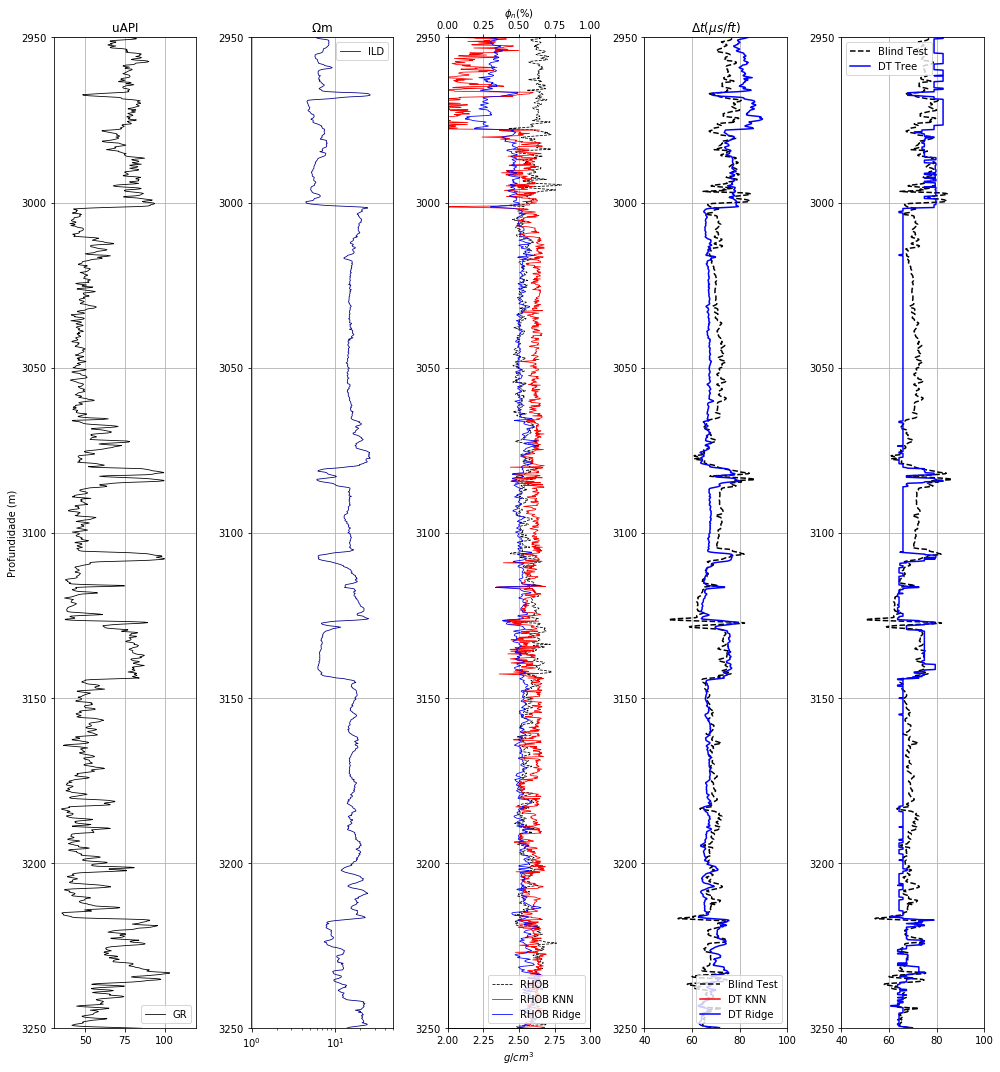

In [40]:
fig, axes = plt.subplots(ncols=5, figsize=(14,15))
axes2 = axes[2].twiny()

axes[0].plot(blind_test.GR, blind_test.DEPT, c='black', label='GR', lw=0.8)
axes[0].set_xlim(30,120)

axes[1].semilogx(blind_test.ILD,blind_test.DEPT, c = 'darkblue', lw=0.8, label='ILD')
axes[1].set_xlim(0,50)

axes[2].plot(blind_test.RHOB, blind_test.DEPT, c = 'black', label='RHOB', lw = 0.8, ls='--')
axes[2].plot(blind_test.RHOB_KNN,blind_test.DEPT, c='red', label='RHOB KNN', lw=0.8)
axes[2].plot(blind_test.RHOB_Ridge, blind_test.DEPT, c='blue', label='RHOB Ridge', lw=0.8)
axes[2].set_xlim(2,3)

# axes2.plot(blind_test.NPHI, blind_test.DEPT, c = 'blue', label = 'NPHI', lw = 0.8, ls='--')
# axes2.set_xlim(0,45)
# axes2.legend(loc='upper right')
# axes2.invert_yaxis()
axes[3].plot(blind_test.DT.loc[(blind_test.DT > 0)].values, 
           blind_test.DEPT.loc[(blind_test.DT > 0)].values, c='black', label='Blind Test', ls='--')
axes[3].plot(blind_test.DT_KNN.loc[(blind_test.GR > 0) & (blind_test.ILD > 0) & (blind_test.RHOB > 0) & (blind_test.CAL > 0)].values, 
             blind_test.DEPT.loc[(blind_test.GR > 0) & (blind_test.ILD > 0) & (blind_test.RHOB > 0) & (blind_test.CAL > 0)].values,
             c='red', label='DT KNN')
axes[3].plot(blind_test.DT_Ridge.loc[(blind_test.GR > 0) & (blind_test.ILD > 0) & (blind_test.RHOB > 0) & (blind_test.CAL > 0)].values, 
             blind_test.DEPT.loc[(blind_test.GR > 0) & (blind_test.ILD > 0) & (blind_test.RHOB > 0) & (blind_test.CAL > 0)].values,
             c='blue', label='DT Ridge')
axes[3].set_xlim(40,100)

axes[4].plot(blind_test.DT.loc[(blind_test.DT > 0)].values, 
             blind_test.DEPT.loc[(blind_test.DT > 0)].values, c='black', label='Blind Test', ls='--')
axes[4].plot(blind_test.DT_dec_tree.loc[(blind_test.GR > 0) & (blind_test.ILD > 0) & (blind_test.RHOB > 0) & (blind_test.CAL > 0)].values, 
             blind_test.DEPT.loc[(blind_test.GR > 0) & (blind_test.ILD > 0) & (blind_test.RHOB > 0) & (blind_test.CAL > 0)].values,
             c='blue', label='DT Tree')
axes[4].set_xlim(40,100)

axes[0].set_title('uAPI')
axes[1].set_title('$\Omega$m')
axes2.set_xlabel('$\phi_n$(%)')
axes[2].set_xlabel('$g/cm^3$')
axes[3].set_title('$\Delta t  (\mu s/ft )$')
axes[0].set_ylabel('Profundidade (m)')


for ax in axes:
    ax.set_ylim(2950,3250)
    ax.invert_yaxis()
    ax.grid()
    ax.legend()
    
axes[2].legend(loc='lower right')
axes[3].legend(loc='lower right')

fig.tight_layout()

In [41]:
blind_test.to_csv(r'C:/Users/mathe/Desktop/MATHEUS/UFBA/IC/shalegas-rad/blind_data.csv')

In [ ]:
fig, axes = plt.subplots(ncols=5, figsize=(14,15))
axes2 = axes[2].twiny()

axes[0].plot(blind_test.GR, blind_test.DEPT, c='black', label='GR', lw=0.8)
axes[0].set_xlim(30,120)

axes[1].semilogx(blind_test.ILD,blind_test.DEPT, c = 'darkblue', lw=0.8, label='ILD')
axes[1].set_xlim(0,50)

axes[2].plot(blind_test.RHOB, blind_test.DEPT, c = 'black', label='RHOB', lw = 0.8, ls='--')
axes[2].plot(blind_test.RHOB_KNN,blind_test.DEPT, c='red', label='RHOB KNN', lw=0.8)
axes[2].plot(blind_test.RHOB_Ridge, blind_test.DEPT, c='blue', label='RHOB Ridge', lw=0.8)
axes[2].set_xlim(2,3)

# axes2.plot(blind_test.NPHI, blind_test.DEPT, c = 'blue', label = 'NPHI', lw = 0.8, ls='--')
# axes2.set_xlim(0,45)
# axes2.legend(loc='upper right')
# axes2.invert_yaxis()
axes[3].plot(blind_test.DT.loc[(blind_test.DT > 0)].values, 
           blind_test.DEPT.loc[(blind_test.DT > 0)].values, c='black', label='Blind Test', ls='--')
axes[3].plot(blind_test.DT_KNN.loc[(blind_test.GR > 0) & (blind_test.ILD > 0) & (blind_test.RHOB > 0) & (blind_test.CAL > 0)].values, 
             blind_test.DEPT.loc[(blind_test.GR > 0) & (blind_test.ILD > 0) & (blind_test.RHOB > 0) & (blind_test.CAL > 0)].values,
             c='red', label='DT KNN')
axes[3].plot(blind_test.DT_Ridge.loc[(blind_test.GR > 0) & (blind_test.ILD > 0) & (blind_test.RHOB > 0) & (blind_test.CAL > 0)].values, 
             blind_test.DEPT.loc[(blind_test.GR > 0) & (blind_test.ILD > 0) & (blind_test.RHOB > 0) & (blind_test.CAL > 0)].values,
             c='blue', label='DT Ridge')
axes[3].set_xlim(40,100)

axes[4].plot(blind_test.DT.loc[(blind_test.DT > 0)].values, 
             blind_test.DEPT.loc[(blind_test.DT > 0)].values, c='black', label='Blind Test', ls='--')
axes[4].plot(blind_test.DT_dec_tree.loc[(blind_test.GR > 0) & (blind_test.ILD > 0) & (blind_test.RHOB > 0) & (blind_test.CAL > 0)].values, 
             blind_test.DEPT.loc[(blind_test.GR > 0) & (blind_test.ILD > 0) & (blind_test.RHOB > 0) & (blind_test.CAL > 0)].values,
             c='blue', label='DT Tree')
axes[4].set_xlim(40,100)

axes[0].set_title('uAPI')
axes[1].set_title('$\Omega$m')
axes2.set_xlabel('$\phi_n$(%)')
axes[2].set_xlabel('$g/cm^3$')
axes[3].set_title('$\Delta t  (\mu s/ft )$')
axes[0].set_ylabel('Profundidade (m)')


for ax in axes:
    ax.set_ylim(2950,3250)
    ax.invert_yaxis()
    ax.grid()
    ax.legend()
    
axes[2].legend(loc='lower right')
axes[3].legend(loc='lower right')

fig.tight_layout()

In [4]:
mean_squared_error(blind_test.loc[blind_test.GR>75].DT,blind_test.loc[blind_test.GR>75].DT_dec_tree)

30.555160160217454

In [5]:
mean_squared_error(blind_test.loc[blind_test.GR<75].DT,blind_test.loc[blind_test.GR<75].DT_dec_tree)

25.390849680449698

In [6]:
mean_squared_error(blind_test.loc[blind_test.GR>75].RHOB,blind_test.loc[blind_test.GR>75].RHOB_dec_tree)

0.03907030783218964

In [7]:
mean_squared_error(blind_test.loc[blind_test.GR<75].RHOB,blind_test.loc[blind_test.GR<75].RHOB_dec_tree)

0.02447913304190918